# **DSCI 100 Group Project**
Authors: 
- Munn Chai
- Deep Shah
- Raihan Arvi
- Ajai Karthikeshan Chockalingam Sivakumar

### **Introduction**

Speed dating is a popular dating practice that involves meeting multiple potential partners in a short period of time. This practice has gained popularity in recent years due to its effectiveness in helping people find compatible partners.


In this proposal, we will attempt to answer the following question: What individual characteristics are most important in predicting the success of speed dating? By analyzing data from a speed dating dataset, we will attempt to identify which factors are most strongly associated with successful matches.


The dataset we use contains information from speed dating events held in different cities in the United States. The dataset is from Department of Statistics, Columbia University. The dataset includes information on participants' demographic characteristics, such as age, education level, and ethnicity, as well as their responses to survey questions related to their personalities, interests, and dating preferences. Additionally, the dataset includes information on whether participants were matched with any of their potential partners.


### Preliminary Exploratory Data Analysis

In [167]:
# Importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(gridExtra)
library(grid)

In [168]:
# Reading the data
speed_dating_data <- read_csv("http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/Speed%20Dating%20Data.csv")

Rows: 8378 Columns: 195
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): field, undergra, from, career
dbl (187): iid, id, gender, idg, condtn, wave, round, position, positin1, or...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [169]:
# Tidying data
speed_dating_select <- speed_dating_data |>
    filter(wave != 6:9) |> # These waves had a different rating system for traits
    mutate(match = as_factor(match),
           gender = as_factor(gender),
           samerace = as_factor(samerace)) |>
    select(match, gender, samerace, age, attr_o, sinc_o, intel_o, fun_o, amb_o)

# Removing improper observations (non-integer values, values not in the range [0, 10])
speed_dating_tidy <- speed_dating_select |>
    filter(attr_o %% 1 == 0,
          sinc_o %% 1 == 0,
          intel_o %% 1 == 0,
          fun_o %% 1 == 0,
          amb_o %% 1 == 0, 
          fun_o <= 10)

# Rename categorical values
levels(speed_dating_tidy$gender)[2] <- "male"
levels(speed_dating_tidy$gender)[1] <- "female"
levels(speed_dating_tidy$match)[2] <- "yes"
levels(speed_dating_tidy$match)[1] <- "no"
levels(speed_dating_tidy$samerace)[2] <- "yes"
levels(speed_dating_tidy$samerace)[1] <- "no"

# Rename columns to be more readable
colnames(speed_dating_tidy) <- c("match", "gender", "same_race", "age", "attractiveness", "sincerity", "intelligence", "funniness", "ambition")

# Preview of tidied dataset
head(speed_dating_tidy)

Warning message in wave != 6:9:
“longer object length is not a multiple of shorter object length”


match,gender,same_race,age,attractiveness,sincerity,intelligence,funniness,ambition
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,female,no,21,6,8,8,8,8
no,female,no,21,7,8,10,7,7
yes,female,yes,21,10,10,10,10,10
yes,female,no,21,7,8,9,8,9
yes,female,no,21,8,7,9,6,9
no,female,no,21,7,7,8,8,7


In [170]:
# Setting seed for consistent results
set.seed(100)

# Splitting Data
speed_dating_split <- initial_split(speed_dating_tidy, prop = 0.75, strata = match)  
speed_dating_train <- training(speed_dating_split)   
speed_dating_test <- testing(speed_dating_split) 
train_rows_before <- nrow(speed_dating_train) 
test_rows_before <- nrow(speed_dating_test)

# Removing NA values
speed_dating_train <- na.omit(speed_dating_train)
speed_dating_test <- na.omit(speed_dating_test)
train_rows_after <- nrow(speed_dating_train)
test_rows_after <- nrow(speed_dating_test)

# Number of NA rows removed
dataset <- c("training_set", "testing_set")
na_rows_removed <- c(train_rows_before - train_rows_after, test_rows_before - test_rows_after)
tibble(dataset, na_rows_removed)

dataset,na_rows_removed
<chr>,<int>
training_set,57
testing_set,16


In [171]:
# Number of observations, split into those that matched, and those that did not
speed_dating_summary <- speed_dating_train |>
    group_by(match, gender) |>
    summarize(count = n())
speed_dating_summary

# Mean values of predictor values
speed_dating_means <- speed_dating_train |>
    group_by(match, gender) |>
    summarize(mean_age = mean(age), 
              mean_attractiveness = mean(attractiveness),
              mean_sincerity = mean(sincerity),
              mean_intelligence = mean(intelligence),
              mean_funniness = mean(funniness),
              mean_ambition = mean(ambition))
speed_dating_means

`summarise()` has grouped output by 'match'. You can override using the
`.groups` argument.


match,gender,count
<fct>,<fct>,<int>
no,female,2210
no,male,2218
yes,female,445
yes,male,457


`summarise()` has grouped output by 'match'. You can override using the
`.groups` argument.


match,gender,mean_age,mean_attractiveness,mean_sincerity,mean_intelligence,mean_funniness,mean_ambition
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,female,26.20498,6.188688,7.163348,7.190045,6.339367,6.515385
no,male,26.66005,5.646528,6.929216,7.317854,5.989179,6.821461
yes,female,25.86067,7.530337,7.813483,7.826966,7.579775,7.224719
yes,male,26.34792,7.155361,7.870897,8.118162,7.625821,7.568928


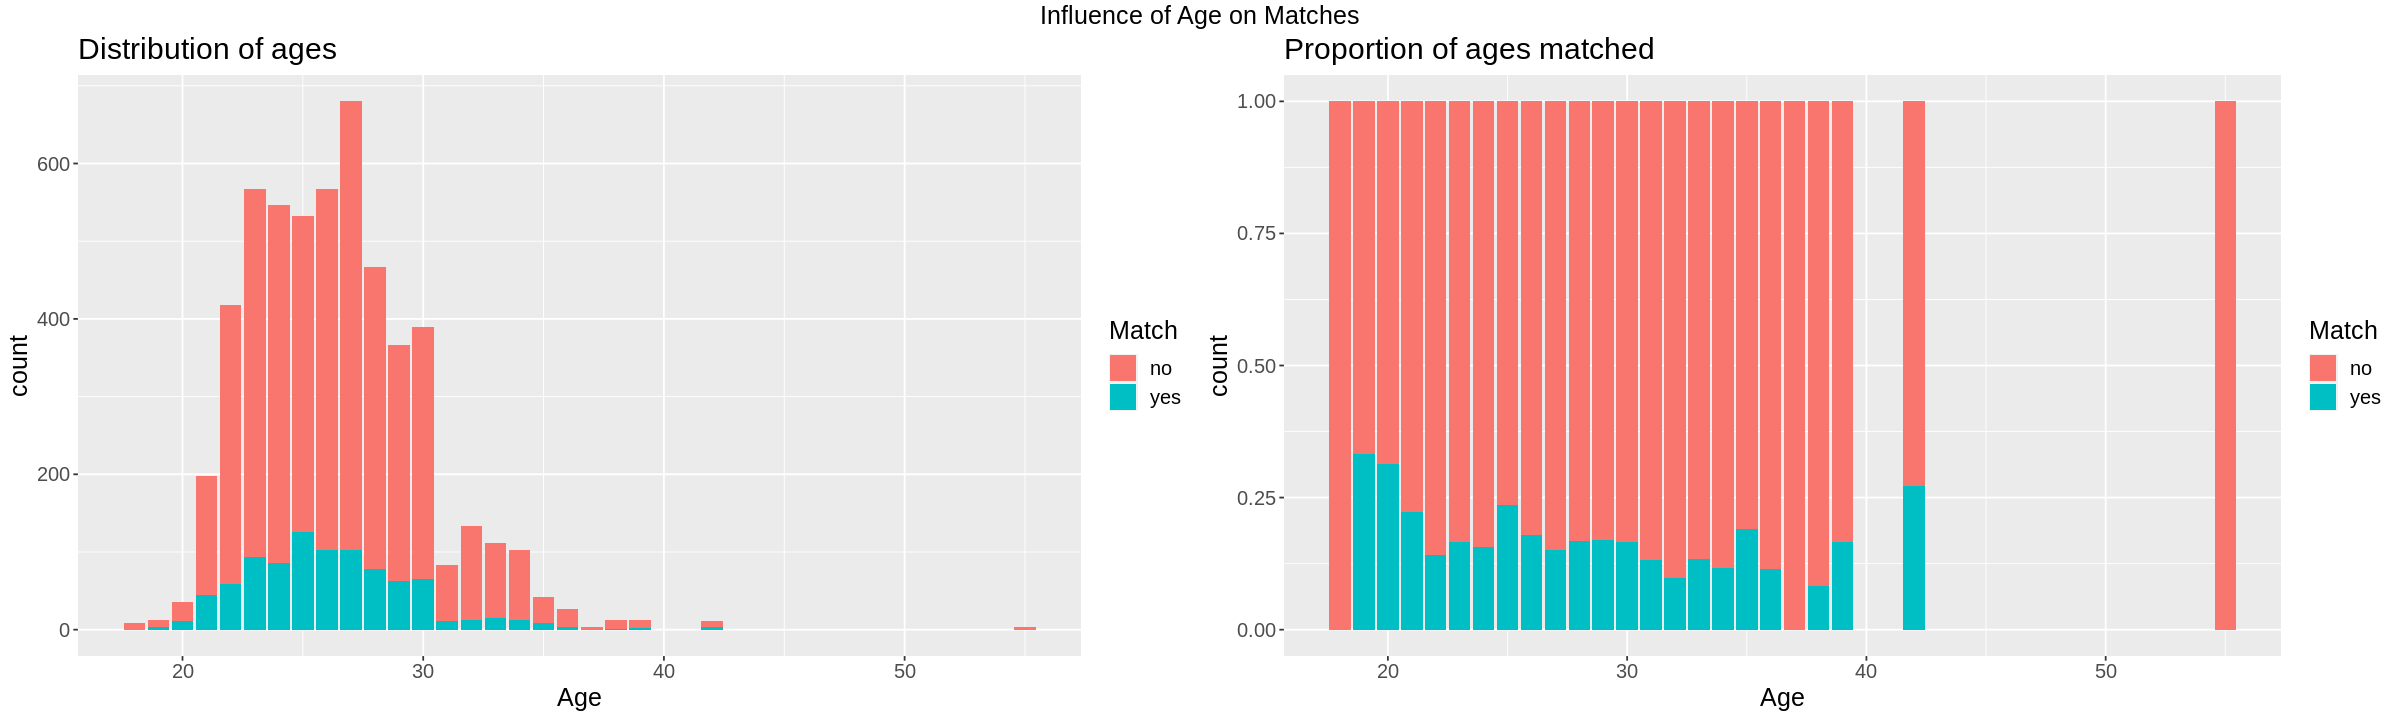

In [172]:
# Distribution of Ages
options(repr.plot.width=20, repr.plot.height=6)

age_distribution <- speed_dating_train |>
    ggplot(aes(x = age, fill = match)) + 
    geom_bar() + 
    labs(x = "Age", fill = "Match") + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Distribution of ages")

# Proportion of Ages
age_proportion <- speed_dating_train |>
    ggplot(aes(x = age, fill = match)) + 
    geom_bar(position = "fill") + 
    labs(x = "Age", fill = "Match") + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Proportion of ages matched")

grid.arrange(age_distribution, age_proportion,
             nrow = 1, top = textGrob("Influence of Age on Matches", gp=gpar(fontsize=15,font=8)))

In [173]:
# Plotting
options(repr.plot.width=25, repr.plot.height=6)

attractiveness_plot <- speed_dating_train |>
    ggplot(aes(x = attractiveness, fill = match)) + 
    labs(x = "Attractiveness", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

sincerity_plot <- speed_dating_train |>
    ggplot(aes(x = sincerity, fill = match)) + 
    labs(x = "Sincerity", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

intelligence_plot <- speed_dating_train |>
    ggplot(aes(x = intelligence, fill = match))+ 
    labs(x = "Intelligence", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

funny_plot <- speed_dating_train |>
    ggplot(aes(x = funniness, fill = match)) + 
    labs(x = "Funniness", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

ambition_plot <- speed_dating_train |>
    ggplot(aes(x = ambition, fill = match)) + 
    labs(x = "Ambition", y = "Count", fill = "Match") + 
    scale_x_continuous(breaks = seq(0, 10, by = 2)) + 
    theme(text = element_text(size = 15))

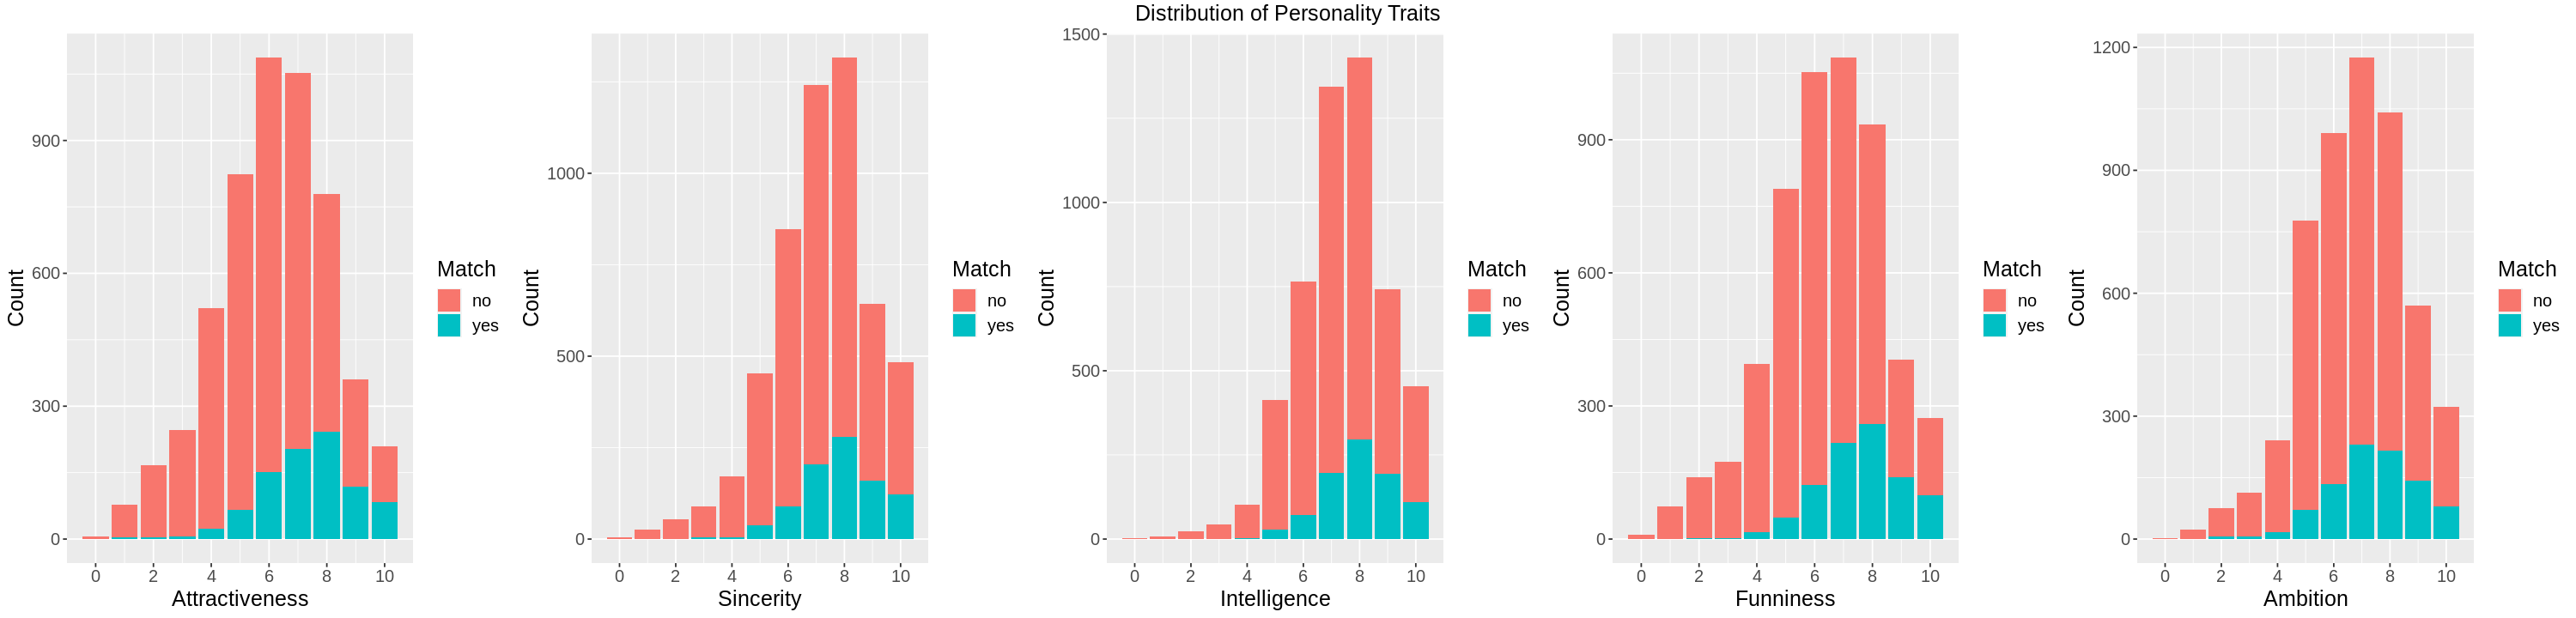

In [174]:
# Distributions of Personality Traits
attractiveness_dist <- attractiveness_plot +
    geom_bar()

sincerity_dist <- sincerity_plot +
    geom_bar()

intelligence_dist <- intelligence_plot +
    geom_bar()

funny_dist <- funny_plot +
    geom_bar()

ambition_dist <- ambition_plot +
    geom_bar()

grid.arrange(attractiveness_dist, sincerity_dist, intelligence_dist, funny_dist, ambition_dist, 
             nrow = 1, top = textGrob("Distribution of Personality Traits", gp=gpar(fontsize=15,font=8)))

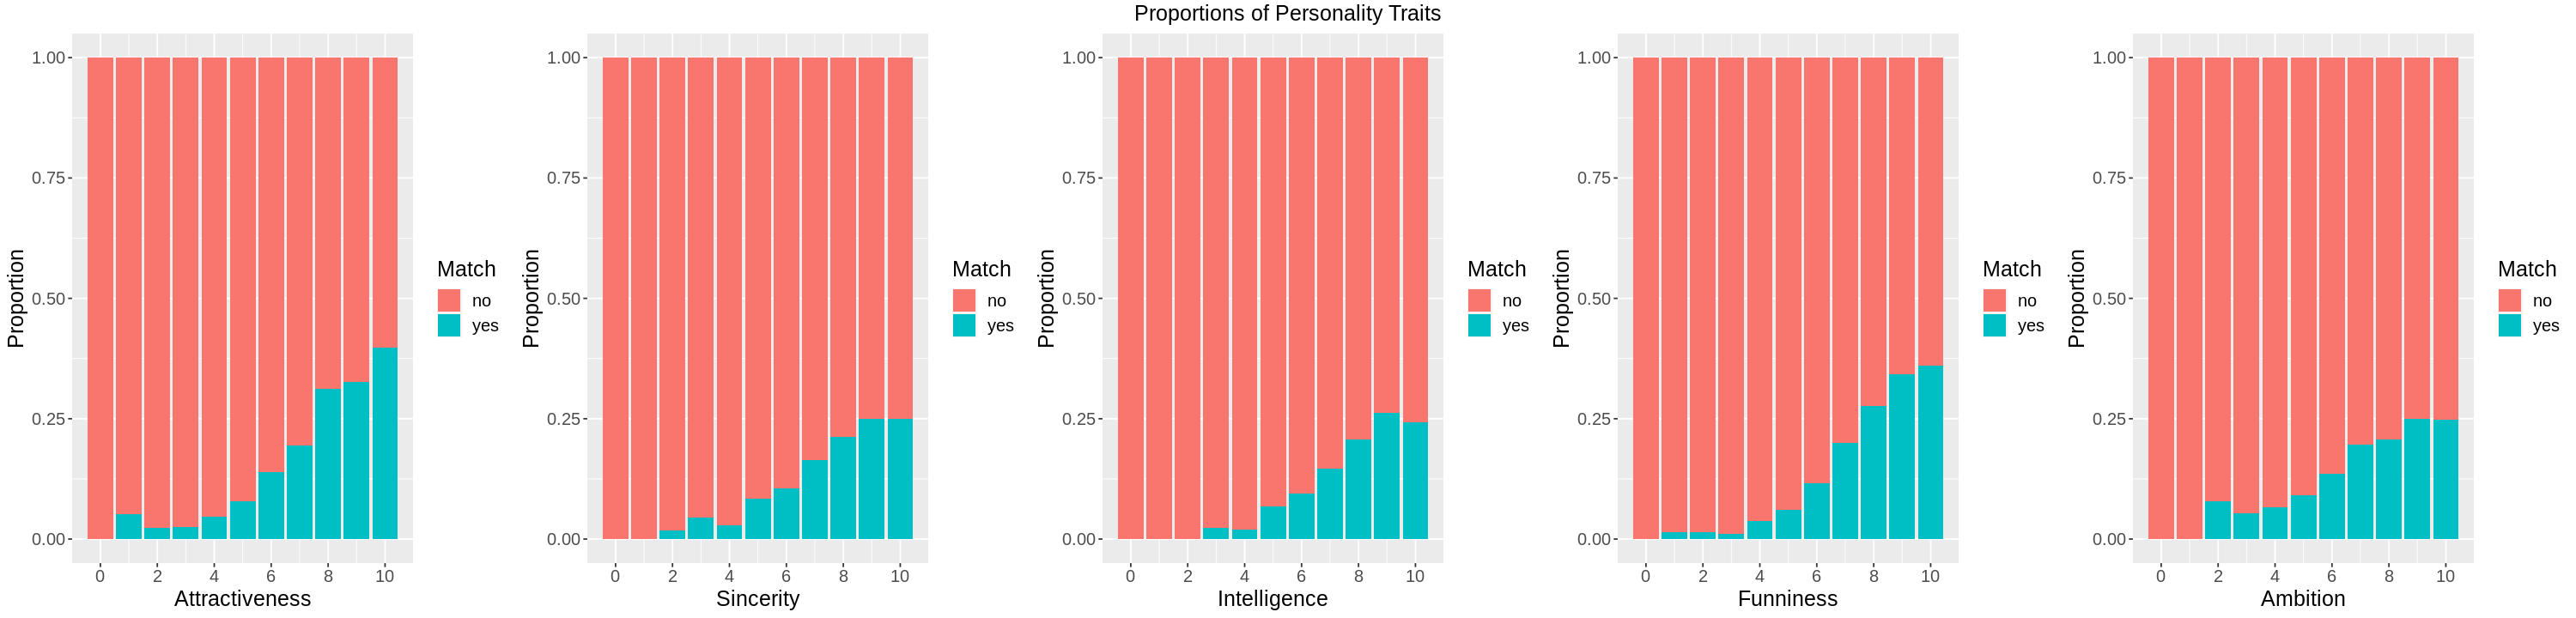

In [175]:
# Proportions of Personality Traits
attractiveness_proportion <- attractiveness_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

sincerity_proportion <- sincerity_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

intelligence_proportion <- intelligence_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

funny_proportion <- funny_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

ambition_proportion <- ambition_plot +
    geom_bar(position = "fill") + 
    labs(y = "Proportion")

grid.arrange(attractiveness_proportion, sincerity_proportion, intelligence_proportion, funny_proportion, ambition_proportion, 
             nrow = 1, top = textGrob("Proportions of Personality Traits", gp=gpar(fontsize=15,font=8)))

### Methods

For our proposal, we analysed the distribution and proportion of ratings for each personality trait that we selected. For our classifier, we intend on using the age, attractiveness, sincerity, intelligence, funniness, and ambition variables to predict whether or not an individual would match with their partner. Our first step was tidying the data that we wanted to use, selecting and renaming the columns that we wanted to use, and filtering out any observations that had unproper values (eg. there was one observation who was rated as 11 on a scale of 0-10). After that, we split the dataset into a training and testing set, with proportions of 75% and 25%, respectively. By grouping and summarizing by the columns "match" and "gender", we were able to find the number of observations in each column, as well as the mean values of the personality trait ratings. From there, we created visualizations of the data by plotting bar graphs with the distributions and proportions of each personality trait. This gives us a clear image of which traits are most important to strengthen, in order to more likely match with a partner. 

Later in this project, we will use the classification method to predict whether a person will match or not based on their reported personality traits. We will predict using the variables age, attractiveness, sincerity, intelligence, funniness, and ambition, and since age is not on a scale of 0-10 like the other traits, we will scale and center the data. To find the most appropriate K-value for our model, we will use the cross-validation method on the training set, using the aforementioned variables. 

### Expected Outcomes and Significance

Upon executing our visual analysis, we expect to find which characteristics prominently lead to a match in speed dating. Looking at the variables individually, we postulate that attraction, sincerity, intelligence, funniness and ambition of an individual should result in a higher probability of a match. Additionally, we expect that individuals that are younger are more likely to have a match percentage, since older generations are generally settled into long relationships already. We are predicting that out of the aforementioned factors, attraction, funniness and age will be the most accurate factors that aid in predicting the success of speed dating.

The impact of these findings are immensely helpful in the matrimonial industry. If dating services understand which factors influence a successful match, they would be able to implement the same in order to give their customers more accurate matches thus positively influencing people's lives. 

Some future questions this could lead to include:
- How do social psychological factors such as first impressions and social norms affect date selection?
- Is there a trend in what individual preferences result in a higher chance of a match?
- What are the patterns of conversation and interaction during speed dating?
- Can we predict which pairs of participants are likely to match based on their own preferences?
- How does the speed dating context influence date selection and relationship outcomes?


###### 